# 전국 도시 공원 표준 데이터
https://www.data.go.kr/dataset/15012890/standard.do
* 전국 도시공원에 대한 분포를 스캐터 차트를 통해 봅니다.
* 어떤 공원이 어느 지역에 어떻게 분포되어 있는지를 경도로 표현해 봅니다.
* 실습을 위해 나눔고딕 폰트가 설치되어 있어야 합니다.
* 이 노트북에서는 pandas, plotnine을 사용합니다.

## 그 외 도시공원 데이터
* 공공데이터 포털에 확인해 보니 전국도시공원표준데이터.xls 외에 202개의 파일이 더 있습니다. 
* https://www.data.go.kr/dataset/15012890/standard.do

## 분석에 사용할 도구를 불러옵니다.

In [1]:
!pip show pandas

Name: pandas
Version: 0.21.0
Summary: Powerful data structures for data analysis, time series,and statistics
Home-page: http://pandas.pydata.org
Author: The PyData Development Team
Author-email: pydata@googlegroups.com
License: BSD
Location: /Users/corazzon/codes/jupyter/lib/python3.6/site-packages
Requires: pytz, python-dateutil, numpy
Required-by: statsmodels, plotnine, mizani, mglearn


In [2]:
!pip show plotnine

Name: plotnine
Version: 0.3.0
Summary: A grammar of graphics for python
Home-page: https://github.com/has2k1/plotnine
Author: Hassan Kibirige
Author-email: has2k1@gmail.com
License: GPL-2
Location: /Users/corazzon/codes/jupyter/lib/python3.6/site-packages
Requires: scipy, pandas, six, numpy, mizani, patsy, statsmodels, matplotlib
Required-by: 


In [3]:
!pip show folium

Name: folium
Version: 0.5.0
Summary: Make beautiful maps with Leaflet.js & Python
Home-page: https://github.com/python-visualization/folium
Author: Rob Story
Author-email: wrobstory@gmail.com
License: Copyright (C) 2013, Rob Story
Location: /Users/corazzon/codes/jupyter/lib/python3.6/site-packages
Requires: requests, six, branca, jinja2
Required-by: 


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
from plotnine import *
import re

# 지도 표현을 위해
import folium

## 데이터 로드

In [6]:
park = pd.read_csv('data/전국도시공원표준데이터.csv', encoding='euc-kr')
park.shape

(13135, 18)

In [7]:
park.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN
3,42800-00004,하리수변공원,수변공원,강원도 양구군 양구읍 하리 643,강원도 양구군 양구읍 하리 643,38.118243,127.981634,18437,NaN,NaN,NaN,NaN,NaN,2010-03-19,강원도 양구군청,033-480-2460,2018-02-28,NaN
4,42800-00005,묘지공원,묘지공원,강원도 양구군 양구읍 죽곡리 산3-1,강원도 양구군 양구읍 죽곡리 산3-1,38.125344,127.999027,178931,NaN,NaN,NaN,NaN,NaN,2010-10-01,강원도 양구군청,033-480-2576,2018-02-28,NaN


## 위경도 시각화

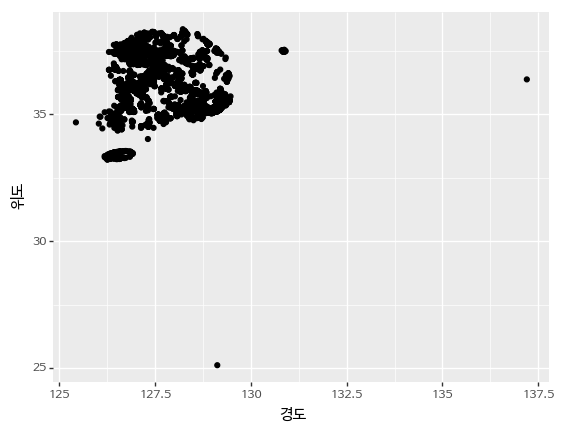

<ggplot: (293071182)>

In [8]:
# 지도를 출력해 보니 특정 지역만 있습니다.
# 결측치인 nan 데이터 때문에 다른 데이터가 제대로 보이지 않습니다.
# nan 데이터를 제거하고 다시 그려봅니다.
(ggplot(park)
 + aes(x='경도', y='위도')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

# 데이터 전처리
* 시도 결측치 처리
    * 다른 데이터로 대체
    * 도로명 혹은 지번 둘 중 하나만 있다면 있는 데이터로 대체
* 아웃라이어 데이터 제거 혹은 대체
    * 위경도가 국내 범위를 벗어나는 데이터의 경우 제외하고 그리도록 처리

In [9]:
# 도로명 주소의 널값 수
park['소재지도로명주소'].isnull().sum()

5898

In [10]:
# 지번 주소의 널값 수
park['소재지지번주소'].isnull().sum()

1204

In [11]:
park.loc[(park['소재지도로명주소'].isnull()) & (park['소재지지번주소'].notnull())].shape

(5898, 18)

In [12]:
park['소재지도로명주소'].fillna(park['소재지지번주소'], inplace = True)

In [13]:
park['소재지도로명주소'].isnull().sum()

0

In [14]:
park_loc = park.loc[(park['소재지도로명주소'].isnull()) & (park['소재지지번주소'].notnull())]
park_loc.shape

(0, 18)

In [15]:
park['시도'] = park['소재지도로명주소'].str.split(' ', expand=True)[0]
park.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17,시도
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도


In [16]:
park['구군'] = park['소재지도로명주소'].str.split(' ', expand=True)[1]
park.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17,시도,구군
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도,양구군
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도,양구군
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도,양구군


In [17]:
park[['위도', '경도']].describe()

,위도,경도
count,13129.000000,13129.000000
mean,36.493476,127.555095
std,1.066760,0.870196
min,25.115601,125.432215
25%,35.568188,126.929027
50%,36.637676,127.141569
75%,37.460255,128.213060
max,38.350990,137.202661


In [18]:
# 위 지도로 위도와 경도의 아웃라이어 데이터를 제외하고 출력해 봅니다.
# 좀 더 정확하게 출력하려면 대한민국 위경도 데이터 범위를 다시 넣어줍니다. 
park_loc_notnull = park.loc[(park['위도'] > 26 ) & (park['경도'] < 132) & park['시도'].notnull()]
park_loc_notnull.shape

(13127, 20)

In [19]:
# 위경도가 잘못입력된 데이터를 봅니다.
# 주소가 잘못되지는 않았습니다.
# 주소를 통해 위경도를 다시 받아올 필요가 있습니다.
park.loc[(park['위도'] < 26 ) | (park['경도'] >= 132)]

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17,시도,구군
7768,26710-00002,굿거리언덕공원,근린공원,부산광역시 기장군 기장읍 내리 800,부산광역시 기장군 기장읍 내리 800,25.115601,129.122735,12124.3,온몸노젓기외 4종,NaN,NaN,NaN,정자 외 3 종,2009-06-30,부산광역시 기장군청,051-709-4531,2017-08-25,NaN,부산광역시,기장군
8175,43113-00080,근린공원5(만수공원),근린공원,충청북도 청주시 흥덕구 오송읍 만수리 512,충청북도 청주시 흥덕구 오송읍 만수리 512,36.374204,137.202661,33258,NaN,NaN,NaN,NaN,NaN,2003-04-18,충청북도 청주시 흥덕구청,043-201-7233,2017-04-01,NaN,충청북도,청주시


In [20]:
park_loc_notnull['시도'].value_counts()

경기도        3675
서울특별시      1226
전라북도       1076
충청북도        904
경상남도        881
울산광역시       822
전라남도        623
강원도         623
부산광역시       610
경상북도        465
충청남도        457
대구광역시       454
대전광역시       421
인천광역시       292
광주광역시       276
제주특별자치도     252
세종특별자치시      70
Name: 시도, dtype: int64

# 시도별 공원 데이터

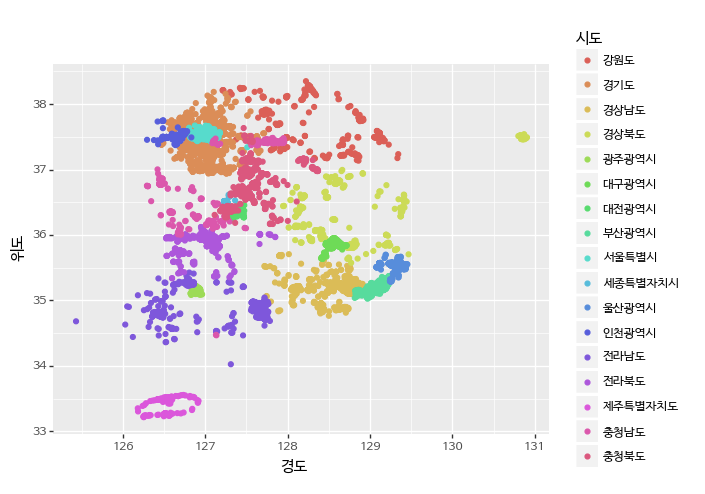

<ggplot: (-9223372036562450898)>

In [21]:
# 지도가 찌그러져 보입니다. 
# 위도와 경도를 평면에 찍어주었는데 우리가 자주 보던 지도와 비슷하게 찍히게 하려면 메카토르 도법을 사용해야 합니다. 
(ggplot(park_loc_notnull)
 + aes(x='경도', y='위도', color='시도')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

### 공원구분별 분포

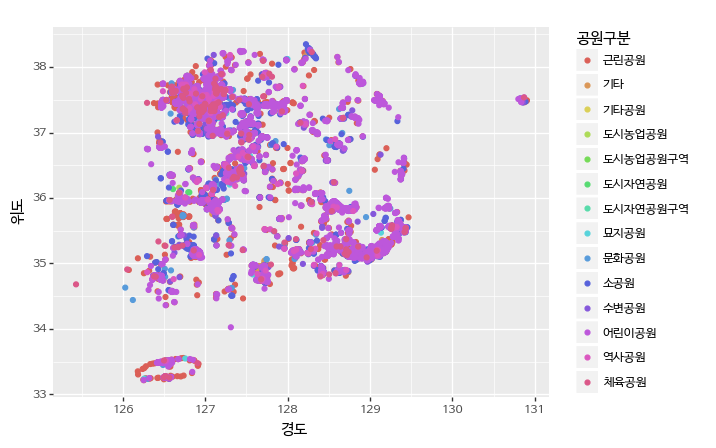

<ggplot: (-9223372036568650678)>

In [22]:
# 전국적으로 어린이 공원이 가장 많은 것으로 보입니다.
# 제주도는 한라산 아래 해안선과 유사한 모습으로 공원이 배치되어 있는 모습이 인상적입니다.
(ggplot(park_loc_notnull)
 + aes(x='경도', y='위도', color='공원구분')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

### 어린이 공원을 제외한  공원구분별 분포도

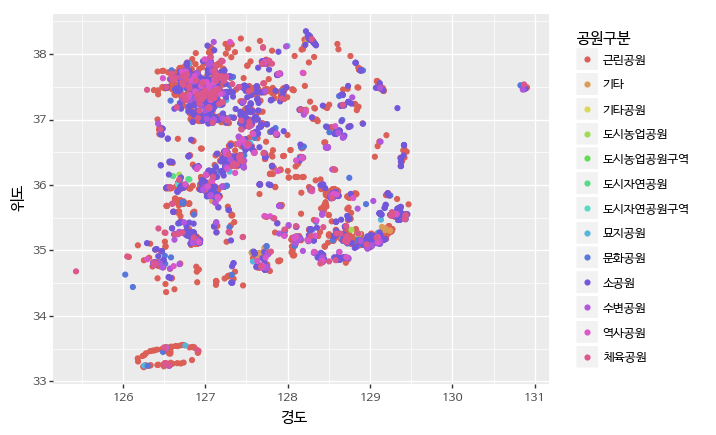

<ggplot: (-9223372036560415835)>

In [23]:
# 어린이공원을 제외하고 찍어보도록 합니다.
# 다음으로 많은 근린공원과 소공원이 많이 보입니다.
(ggplot(park_loc_notnull.loc[park_loc_notnull['공원구분'] != '어린이공원'])
 + aes(x='경도', y='위도', color='공원구분')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [24]:
park_loc_notnull.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17,시도,구군
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도,양구군
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도,양구군
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도,양구군
3,42800-00004,하리수변공원,수변공원,강원도 양구군 양구읍 하리 643,강원도 양구군 양구읍 하리 643,38.118243,127.981634,18437,NaN,NaN,NaN,NaN,NaN,2010-03-19,강원도 양구군청,033-480-2460,2018-02-28,NaN,강원도,양구군
4,42800-00005,묘지공원,묘지공원,강원도 양구군 양구읍 죽곡리 산3-1,강원도 양구군 양구읍 죽곡리 산3-1,38.125344,127.999027,178931,NaN,NaN,NaN,NaN,NaN,2010-10-01,강원도 양구군청,033-480-2576,2018-02-28,NaN,강원도,양구군


### 시도별 공원 비율

In [25]:
# 시도별로 합계 데이터를 출력
park_do = pd.DataFrame(park['시도'].value_counts())
park_do_normalize = pd.DataFrame(park['시도'].value_counts(normalize=True))
park_sido = park_do.merge(park_do_normalize, left_index=True, right_index=True).reset_index()
park_sido.columns = ['시도', '합계', '비율']
park_sido.sort_values(by=['합계'], ascending=False)
park_sido

,시도,합계,비율
0,경기도,3675,0.279787
1,서울특별시,1230,0.093643
2,전라북도,1076,0.081919
3,충청북도,905,0.068900
4,경상남도,881,0.067073
5,울산광역시,822,0.062581
6,전라남도,623,0.047431
7,강원도,623,0.047431
8,부산광역시,613,0.046669
9,경상북도,465,0.035402


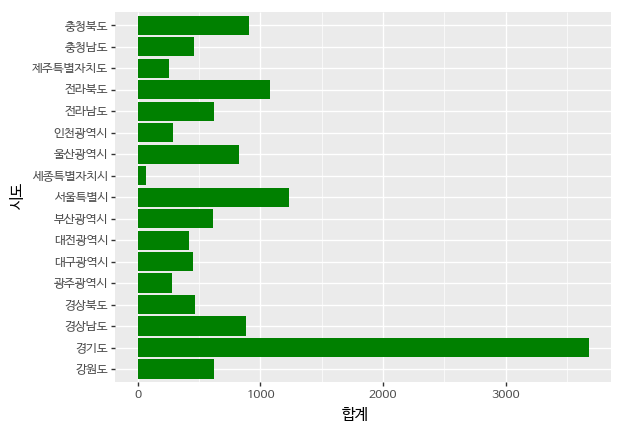

<ggplot: (-9223372036559806222)>

In [26]:
# 경기도가 압도적으로 많음
(ggplot(park_sido.sort_values(by=['합계'], ascending=False))
 + aes(x='시도', y='합계')
 + geom_bar(stat='identity', position='dodge', fill='green')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [27]:
park_type = park['공원구분'].value_counts().reset_index()
park_type.columns = ('공원구분', '합계')
park_type

,공원구분,합계
0,어린이공원,7375
1,근린공원,3148
2,소공원,1723
3,문화공원,205
4,수변공원,199
5,체육공원,162
6,기타,159
7,역사공원,115
8,묘지공원,35
9,도시농업공원,5


### 공원구분별 합계

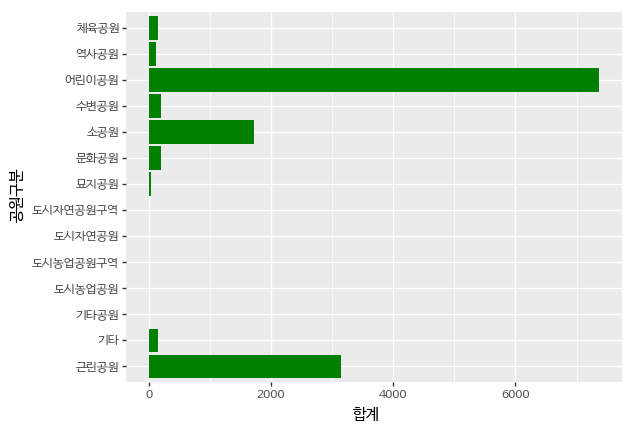

<ggplot: (-9223372036561386089)>

In [28]:
(ggplot(park_type)
 + aes(x='공원구분', y='합계')
 + geom_bar(stat='identity', position='dodge', fill='green')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

## 경기도
* 경기도에는 가장 많은 공원이 있습니다. 
* 어떻게 분포되어 있는지 보겠습니다.

In [29]:
gg = park.loc[park['시도'] == '경기도']
gg.shape

(3675, 20)

In [30]:
gg_park = gg['공원구분'].value_counts().reset_index()
gg_park.columns = ('공원구분', '합계')
gg_park

,공원구분,합계
0,어린이공원,2037
1,근린공원,894
2,소공원,475
3,문화공원,76
4,체육공원,73
5,수변공원,64
6,역사공원,34
7,묘지공원,12
8,기타,10


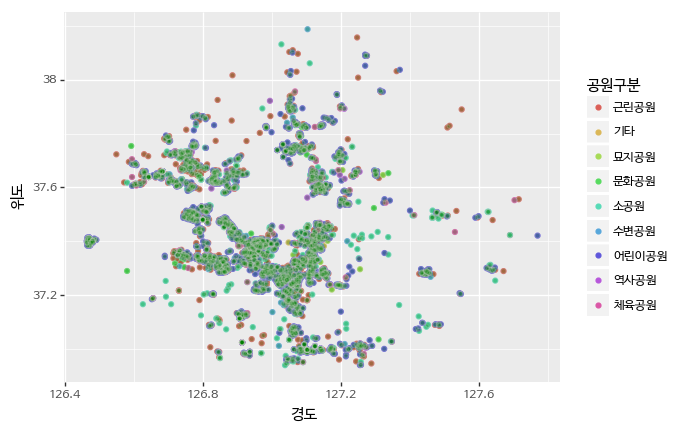

<ggplot: (292360908)>

In [31]:
(ggplot(gg)
 + aes(x='경도', y='위도', color='공원구분') 
 + geom_point()
 + geom_jitter(fill='green', color='lightgray', alpha=0.25)
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [32]:
gg_suwon = gg.loc[gg['구군'] == '수원시']

In [33]:
geo_df = gg_suwon
map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], zoom_start=13)

for n in geo_df.index:
    park_name = geo_df['공원명'][n] + ' - ' + geo_df['소재지도로명주소'][n]
    folium.Marker([geo_df['위도'][n], geo_df['경도'][n]], popup=park_name).add_to(map)
    
map

전체 공원을 다 찍어 보면 너무 많아서 잘 구분이 안 되기 때문에 몇 가지 공원만 따로 찍어 봅니다.

## 경기도 일부 공원만 보기

In [34]:
park_type = r'.*((역사|체육|수변|문화|묘지)공원).*'
gg_sample = gg.loc[gg['공원구분'].str.match(park_type)]

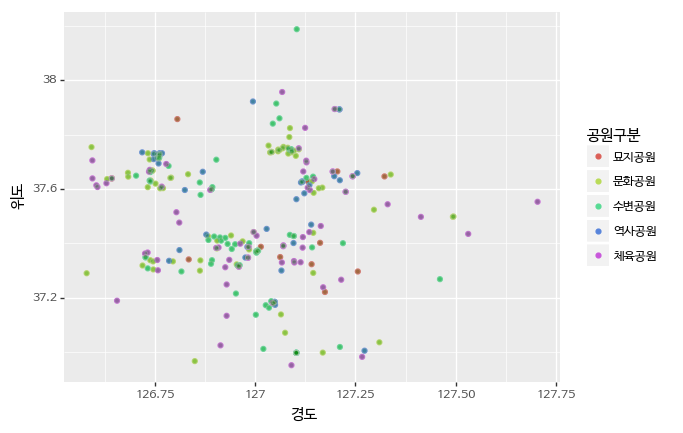

<ggplot: (-9223372036559814768)>

In [35]:
(ggplot(gg_sample)
 + aes(x='경도', y='위도', color='공원구분') 
 + geom_point()
 + geom_jitter(fill='green', color='lightgray', alpha=0.25)
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [36]:
gg_sample.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17,시도,구군
463,41220-00057,현촌한마음공원,문화공원,경기도 평택시 용이동 596-7,경기도 평택시 용이동 596-7,36.966736,126.849719,6694,운동기구,NaN,화장실,NaN,"산책로, 광장",2010-09-24,평택시청(공원과),031-8024-4241,2018-02-19,NaN,경기도,평택시
464,41220-00058,물빛수변공원1,수변공원,경기도 평택시 비전동 999,경기도 평택시 비전동 999,36.997279,127.102611,39061,NaN,NaN,공원등,NaN,산책로,2007-11-07,평택시청(공원과),031-8024-4241,2018-02-19,NaN,경기도,평택시
465,41220-00059,물빛수변공원2,수변공원,경기도 평택시 비전동 1016,경기도 평택시 비전동 1016,36.997279,127.102611,11228,운동기구,NaN,램프,NaN,산책로,2007-11-07,평택시청(공원과),031-8024-4241,2018-02-19,NaN,경기도,평택시


In [37]:
# 경기도 일부 공원만 지도에 표기
geo_df = gg_sample

map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], zoom_start=11)

for n in geo_df.index:
    park_name = geo_df['공원명'][n] + ' - ' + geo_df['소재지도로명주소'][n]
    folium.Marker([geo_df['위도'][n], geo_df['경도'][n]], popup=park_name).add_to(map)
    
map

## 서울특별시

In [38]:
seoul = park.loc[park['시도'] == '서울특별시']
seoul.shape

(1230, 20)

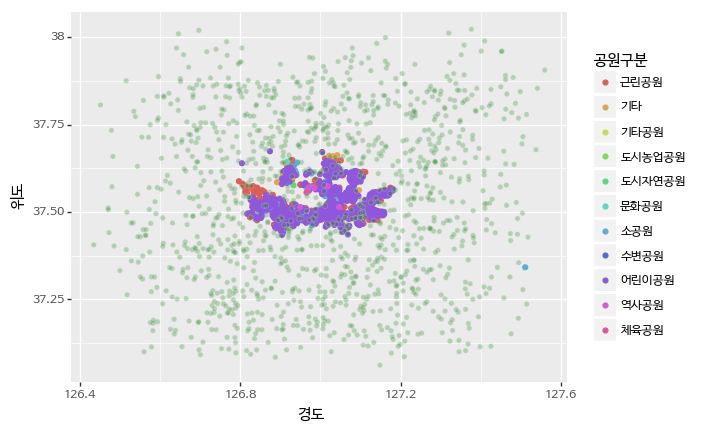

<ggplot: (293391529)>

In [39]:
(ggplot(seoul)
 + aes(x='경도', y='위도', color='공원구분') 
 + geom_point()
 + geom_jitter(fill='green', color='lightgray', alpha=0.25)
 + scale_fill_gradient(low = 'green', high = 'brown') 
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [40]:
park['공원구분'].value_counts()

어린이공원       7375
근린공원        3148
소공원         1723
문화공원         205
수변공원         199
체육공원         162
기타           159
역사공원         115
묘지공원          35
도시농업공원         5
도시자연공원         5
도시자연공원구역       2
도시농업공원구역       1
기타공원           1
Name: 공원구분, dtype: int64

In [41]:
seoul_playground = park.loc[(park['공원구분'] == '어린이공원') & (park['시도'] == '서울특별시')]

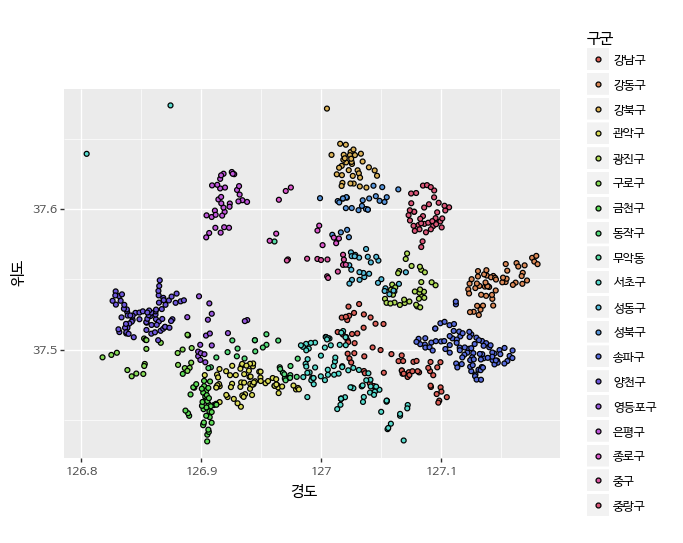

<ggplot: (-9223372036558560782)>

In [42]:
# 특정 지역에는 어린이 공원이 부족해 보입니다. 왜 그럴까요?
(ggplot(seoul_playground)
 + aes(x='경도', y='위도', fill='구군')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

## 구별 공원 분포

In [43]:
gu = '강남구 강동구 강북구 강서구 관악구 광진구 구로구 금천구 노원구 도봉구 동대문구 동작구 마포구 서대문구 서초구 성동구 성북구 송파구 양천구 영등포구 용산구 은평구 종로구 중구 중랑구'
gu = gu.split(' ')
print('서울에는 {}개의 구가 있다.'.format(len(gu)))

서울에는 25개의 구가 있다.


In [44]:
# 무악동이 구군 데이터에 잘못 들어와 있다. 전처리 해줄 필요가 있다.
seoul_playground_gu = seoul_playground['구군'].value_counts().reset_index()
seoul_playground_gu_count = seoul_playground_gu.shape[0]
seoul_playground_gu.columns = ['구군', '합계']
seoul_playground_gu = seoul_playground_gu.sort_values(by='합계', ascending=False)
# 누락된 구를 찾기 위해 데이터프레임에 들어있는 구군을 추출한다.
seoul_playground_gu_unique = seoul_playground_gu['구군'].unique()

print('아래 데이터를 보니 몇개 구가 누락된것을 알 수 있다. 전체 {}개 구 중 {}개 구만 있다.'.format(len(gu), seoul_playground_gu_count))
exclude_gu = [g for g in gu if not g in seoul_playground_gu_unique] 
print('누락된 구: {}'.format(exclude_gu))
error_gu = [g for g in seoul_playground_gu_unique if not g in gu] 
print('잘못들어간 구: {}'.format(error_gu))

seoul_playground_gu

아래 데이터를 보니 몇개 구가 누락된것을 알 수 있다. 전체 25개 구 중 19개 구만 있다.
누락된 구: ['강서구', '노원구', '도봉구', '동대문구', '마포구', '서대문구', '용산구']
잘못들어간 구: ['무악동']


,구군,합계
0,송파구,89
1,서초구,85
2,양천구,73
3,관악구,64
4,강남구,64
5,강동구,53
6,중랑구,41
7,금천구,41
8,강북구,35
10,광진구,34


In [45]:
seoul_playground.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17,시도,구군
1476,11680-00056,논현목련공원,어린이공원,서울특별시 강남구 논현동 137-18,서울특별시 강남구 논현동 137-18,37.510851,127.017942,986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02-3423-6247,2017-11-16,NaN,서울특별시,강남구
1646,11380-00050,다래어린이공원,어린이공원,서울특별시 은평구 응암동 115-55,"서울특별시 은평구 응암동 751-22, 23",37.587111,126.919033,584.9,NaN,"조합놀이대1, 그네1, 유아용조합놀이대1, 흔들놀이2",NaN,NaN,NaN,2004-12-27,서울특별시 은평구시설관리공단,02-350-5254,2017-07-12,NaN,서울특별시,은평구
1648,11380-00052,응암9구역어린이공원,어린이공원,서울특별시 은평구 응암동 115-57,서울특별시 은평구 응암동670-25외16필지,37.586731,126.923094,1217.8,NaN,"조합놀이대1, 경사놀이대1, 그네1, 시소1, 미끄럼틀1, 흔들놀이1, 유아놀이대1...",NaN,NaN,NaN,2005-12-29,서울특별시 은평구시설관리공단,02-350-5254,2017-07-12,NaN,서울특별시,은평구
1741,11380-00071,시내어린이공원,어린이공원,서울특별시 은평구 응암동 115-76,서울특별시 은평구 불광동 444-15,37.624806,126.927410,659,NaN,"조합놀이대1, 그네1, 시소1, 흔들놀이2",NaN,NaN,NaN,NaN,서울특별시 은평구시설관리공단,02-350-5254,2017-07-12,NaN,서울특별시,은평구
1742,11380-00072,가람어린이공원,어린이공원,서울특별시 은평구 응암동 115-77,서울특별시 은평구 불광동 448-11,37.626369,126.925398,249,NaN,조합놀이대1,NaN,NaN,NaN,NaN,서울특별시 은평구시설관리공단,02-350-5254,2017-07-12,NaN,서울특별시,은평구


### 강남3구 공원 분포

In [46]:
# 위 데이터에서는 송파, 서초, 양천, 강남구에 공원이 많은 것으로 보여집니다.
# 강남3구는 공원만 표시해 봅니다.
geo_df = seoul_playground.loc[seoul_playground['구군'].str.match( r'((강남|서초|송파)구)')]
geo_df = geo_df.loc[(geo_df['위도'].notnull()) & (geo_df['경도'].notnull())]
geo_df.isnull().sum()

관리번호              0
공원명               0
공원구분              0
소재지도로명주소          0
소재지지번주소          89
위도                0
경도                0
공원면적              0
공원보유시설(운동시설)    236
공원보유시설(유희시설)    236
공원보유시설(편익시설)    236
공원보유시설(교양시설)    236
공원보유시설(기타시설)    236
지정고시일            81
관리기관명            62
전화번호              0
데이터기준일자           0
Unnamed: 17     236
시도                0
구군                0
dtype: int64

In [47]:
geo_df.shape

(236, 20)

In [48]:
map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], zoom_start=13)

for n in geo_df.index:
    park_name = geo_df['공원명'][n] + ' - ' + geo_df['소재지도로명주소'][n]
    folium.Marker([geo_df['위도'][n], geo_df['경도'][n]], popup=park_name).add_to(map)
map

### 누락 데이터

* 공공데이터 포털에 확인해 보니 전국도시공원표준데이터.xls 외에 202개의 파일이 더 있습니다.
* https://www.data.go.kr/dataset/15012890/standard.do

* 그럼 서울시에 어린이 공원을 포함해 어떤 공원들이 있는지?

In [49]:
# 서울에는 주로 어떤 공원이 있을까?
seoul['공원구분'].value_counts()

어린이공원     763
근린공원      292
소공원       113
기타         42
문화공원        6
역사공원        6
수변공원        3
도시자연공원      2
도시농업공원      1
기타공원        1
체육공원        1
Name: 공원구분, dtype: int64

In [50]:
# 경기도는 어떨까요?
gg['공원구분'].value_counts()

어린이공원    2037
근린공원      894
소공원       475
문화공원       76
체육공원       73
수변공원       64
역사공원       34
묘지공원       12
기타         10
Name: 공원구분, dtype: int64

In [51]:
park.columns

Index(['관리번호', '공원명', '공원구분', '소재지도로명주소', '소재지지번주소', '위도', '경도', '공원면적',
       '공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)',
       '공원보유시설(기타시설)', '지정고시일', '관리기관명', '전화번호', '데이터기준일자', 'Unnamed: 17',
       '시도', '구군'],
      dtype='object')

In [52]:
park_sq = seoul[['시도', '구군', '공원면적']]
park_sq.head()

,시도,구군,공원면적
804,서울특별시,강남구,679.3
1024,서울특별시,강남구,1799.5
1202,서울특별시,강남구,1343
1265,서울특별시,강남구,1688.1
1278,서울특별시,강남구,427.6


In [53]:
park_unique = pd.pivot_table(park, index=['시도', '구군'], columns='공원구분')
park_unique.head()

경도                                                   \
공원구분           근린공원          기타 기타공원 도시농업공원 도시농업공원구역 도시자연공원 도시자연공원구역   
시도  구군                                                                 
강원도 강릉시  128.877562         NaN  NaN    NaN      NaN    NaN      NaN   
    고성군  128.282820  128.265505  NaN    NaN      NaN    NaN      NaN   
    동해시  129.113660         NaN  NaN    NaN      NaN    NaN      NaN   
    삼척시  129.165181         NaN  NaN    NaN      NaN    NaN      NaN   
    양구군         NaN         NaN  NaN    NaN      NaN    NaN      NaN   

                                               ...          위도         \
공원구분           묘지공원        문화공원         소공원    ...    도시농업공원구역 도시자연공원   
시도  구군                                         ...                      
강원도 강릉시         NaN  128.915411  128.855840    ...         NaN    NaN   
    고성군         NaN         NaN  128.279403    ...         NaN    NaN   
    동해시         NaN         NaN  129.103602    ...         NaN    NaN   
    삼척시         NaN         NaN  129.247329    ...         NaN    NaN   
    양구군  127.999027         NaN         NaN    ...         NaN    NaN   

                                                                              \
공원구분    도시자연공원구역       묘지공원       문화공원        소공원       수변공원      어린이공원 역사공원   
시도  구군                                                                         
강원도 강릉시      NaN        NaN  37.751991  37.810613        NaN  37.775079  NaN   
    고성군      NaN        NaN        NaN  38.229283        NaN  38.265700  NaN   
    동해시      NaN        NaN        NaN  37.509552  37.486651  37.507288  NaN   
    삼척시      NaN        NaN        NaN  37.311655        NaN  37.416685  NaN   
    양구군      NaN  38.125344        NaN        NaN  38.118243  38.105019  NaN   

                   
공원구분         체육공원  
시도  구군             
강원도 강릉시       NaN  
    고성군  38.23085  
    동해시       NaN  
    삼척시       NaN  
    양구군       NaN  

[5 rows x 28 columns]

# 제주도 

In [54]:
jeju = park.loc[park['시도'] == '제주특별자치도']
jeju.shape

(252, 20)

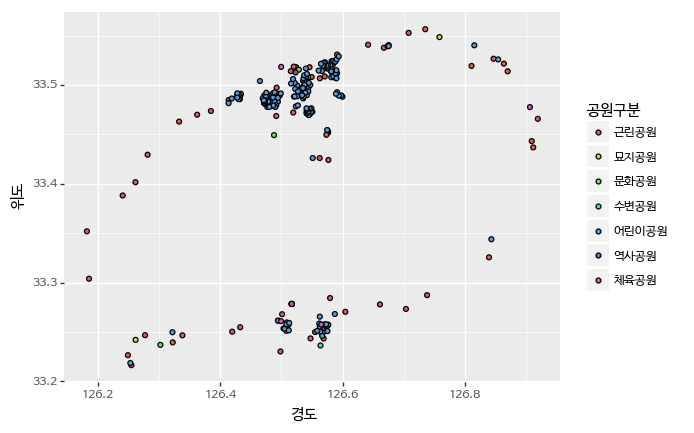

<ggplot: (-9223372036559916214)>

In [55]:
(ggplot(jeju)
 + aes(x='경도', y='위도', fill='공원구분')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [56]:
geo_df = jeju

map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], zoom_start=11)

for n in geo_df.index:
    park_name = geo_df['공원명'][n] + ' - ' + geo_df['소재지도로명주소'][n]
    folium.Marker([geo_df['위도'][n], geo_df['경도'][n]], popup=park_name).add_to(map)

map